# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## Initialize Environment

In [1]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re
from functools import partial

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

# Pre-trained models
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler


def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../bin/data'
embeddings_path = '../bin/word_embeddings'

from util.datafunctions import *
from util.evaluation import *

if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda'

DEVICE

2024-03-02 19:33:58.816780: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 19:33:58.839813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 19:33:58.839837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 19:33:58.840503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 19:33:58.844558: I tensorflow/core/platform/cpu_feature_guar

'cuda'

## Raw Data

### Loading

Load the data into pandas dataframes

In [2]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [3]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'binary_label', 'label_y': 'label_detailed'})

In [4]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'label'] = 0
train_data.loc[train_data['binary_label'].isin([2,3,4]), 'label'] = 1

In [5]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

test_data['label'] = -1 # for compatibility with the dataloader, set a dummy label variable

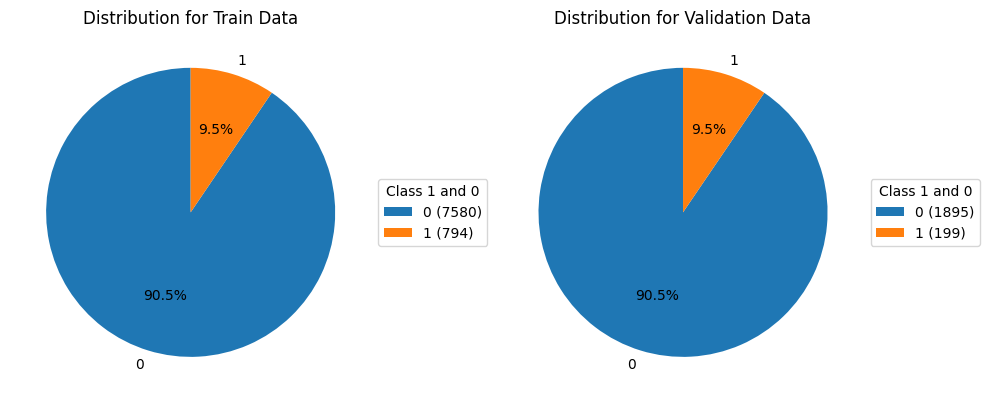

In [6]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data)

pie_data_distributions([y_train, y_val], ['Train Data', 'Validation Data'])

## Pre-processing

### Tokenization

In [7]:
from typing import List

def tokenize_text(text: List[str], tokenizer: BertTokenizer, max_length: int = 300):
    """Tokenize the input text using the provided tokenizer

    Args:
        text (List[str]): input text
        tokenizer (BertTokenizer): tokenizer to be used
        max_length (int, optional): maximum length of the tokenized text. Defaults to 300.

    Returns:
        dict: dictionary containing the tokenized text
    """    

    # We pad shorter sentences to a length of trunc_len tokens since the maximum sequence size for BERT is 512
    return tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

### 1. Masking Tokens

In [8]:
def mask_tokens(inputs, tokenizer, mlm_probability):
    """Given a tokenized input, will prepare masked tokens inputs/labels for Masked Language Modelling. 'We want to train BERT to predict an mlm_probability% of tokens (in the original paper it is 15%) of which 80% will be replaced by a ``[MASK]`` token, 10% with a random token and 10% remain the same token.' (from tutorial)

    Args:
        inputs (list): list of inputs to be masked
        tokenizer (BertTokenizer): tokenizer to be used
        mlm_probability (float): probability of applying a mask to each token

    Returns:
        (maksed tokens, original token): _description_
    """    

    assert tokenizer.mask_token is not None and "Tokenizer should not be none. (how can we mask if we don't know what to call it!)"

    labels = inputs.clone()

    # We sample a few tokens in each sequence for masked-LM training (with probability mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)

    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

### 2. Stop Word Removal

explanation: https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

we don't always remove stop words, e.g. https://www.ibm.com/docs/en/watson-explorer/11.0.0?topic=analytics-stop-word-removal when a sentence consists only of stop words, but this library takes care of it"Surprisingly, the stopwords received as much attention as non-stop words, but removing them has no effect in MRR performances." https://stackoverflow.com/questions/63633534/is-it-necessary-to-do-stopwords-removal-stemming-lemmatization-for-text-classif 

In [9]:
from gensim.parsing.preprocessing import remove_stopwords

# Another sample text
new_text = "I do not like you because I'm better than you"
 
# Remove stopwords using Gensim
new_filtered_text = remove_stopwords(new_text)

print("Original Text:", new_text)
print("Text after Stopword Removal:", new_filtered_text)

Original Text: I do not like you because I'm better than you
Text after Stopword Removal: I like I'm better


## Data Sampling

### 1. "Easy Data Augmentation Techniques"

(Initially) Inspired by https://datascience.stackexchange.com/questions/27671/how-do-you-apply-smote-on-text-classification 

Code implemented from https://arxiv.org/pdf/1901.11196.pdf

In [10]:
!git clone https://github.com/jasonwei20/eda_nlp.git
from eda_nlp.code.eda import *

fatal: destination path 'eda_nlp' already exists and is not an empty directory.


In [11]:
# Default parameters have shown good performance in the original paper
eda("I hate you because I think that I'm better than you", alpha_ri=0.0, num_aug=5)

['i hate you because i remember that im better than you',
 'hate because i think that im better than you',
 'i because you hate i think that im better than you',
 'i hate you because i think that im better than you',
 'i hate you because i retrieve that im better than you',
 'i hate you because i think that im better than you']

In [12]:
def generate_eda(data):
    num_aug = 3

    eda_upsampled = data[data['label'] == 1]
    eda_upsampled.loc[:, 'text'] = eda_upsampled.apply(lambda row: eda(row['text'], alpha_ri=0.0, num_aug=num_aug), axis=1)

    upsampled_positives = pd.DataFrame(columns=data.columns)

    for _, row in eda_upsampled.iterrows():
        for upsample in row['text']:
            # insert into upsampled_positives the row['text'] and the remaining columns in variable row
            new_row = pd.DataFrame([row], columns=data.columns)
            new_row['text'] = upsample
            upsampled_positives = pd.concat([upsampled_positives, new_row], ignore_index=True)

    train_data_minority_upsampled = pd.concat([upsampled_positives, data[data['label'] == 0]], ignore_index=True)

    return train_data_minority_upsampled

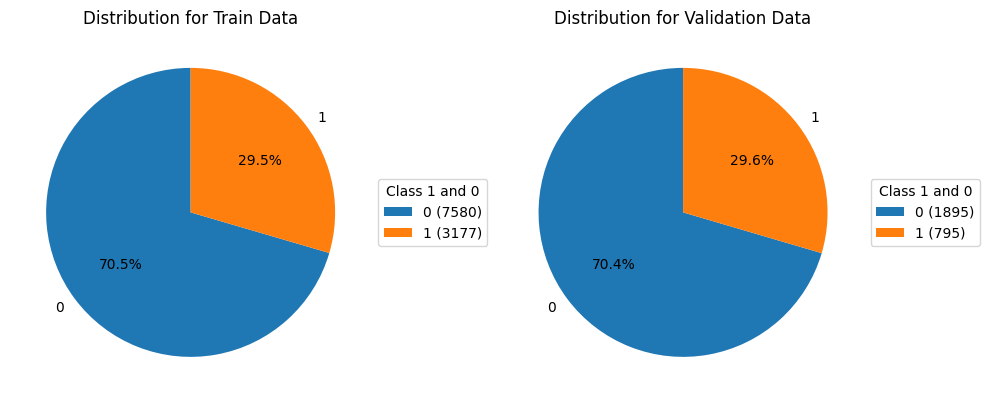

In [13]:
train_data_minority_upsampled = generate_eda(train_data)

X_train, X_val, y_train, y_val = generate_data_splits(train_data_minority_upsampled)
pie_data_distributions([y_train, y_val], ['Train Data', 'Validation Data'])

## Collecting Data For Model

### Dataset

In [14]:
# Creating Datasets for formatting entries from the PCL dataset.
class PCLDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame
                 , tokenizer: BertTokenizer
                 , mask_tokens = False
                 , trunc_len = 300
                 , mlm_probability = 0.15):
        """Initializes the PCLDataset class"""

        self.data = data_frame
        self.tokenizer = tokenizer
        self.mask = mask_tokens
        self.trunc_len = trunc_len
        self.mlm_probability = mlm_probability        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Returns a singular item with all pre-processing required for the tester"""

        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        # instead of label and label_detailed we use label
        label = {'label': self.data['label'].iloc[idx]}

        return data, label
    
    def collate_fn(self, batch):
        """merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style"""
        
        input_features = [i for i, _ in batch]
        output_labels  = [o for _, o in batch]

        # 1. Tokenize the input text
        batched_text = [item['text'] for item in input_features]
        encodings = tokenize_text(batched_text, self.tokenizer, self.trunc_len)

        # 2. Optionally mask the input
        if self.mask:
            masked_input, labels = mask_tokens(encodings['input_ids'], self.tokenizer, self.mlm_probability)
            encodings['input_ids'] = masked_input
            encodings['labels'] = labels

        # 3. Process the output labels
        encodings['labels'] = torch.tensor([item['label'] for item in output_labels])

        return encodings

### Data Sampling



In [15]:
# Upsample the minority class

X_train, X_val, y_train, y_val = generate_data_splits(train_data)

sampled_train_data = pd.merge(X_train, y_train, left_index=True, right_index=True)
sampled_val_data = pd.merge(X_val, y_val, left_index=True, right_index=True)

sampled_train_data = generate_eda(sampled_train_data)

## Model

#### bert-base-cased

In [16]:
# model = BERT_hate_speech.from_pretrained('bert-base-cased')

model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

test_dataset = PCLDataset(test_data, mask_tokens=False, tokenizer=tokenizer)
training_dataset = PCLDataset(sampled_train_data, mask_tokens=False, tokenizer=tokenizer)
val_dataset = PCLDataset(sampled_val_data, mask_tokens=False, tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="models/bert-base-cased",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=val_dataset,
    data_collator=training_dataset.collate_fn,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anton-zhitomirsky (anton-zhitomirsky-joe-mama). Use `wandb login --relogin` to force relogin


 37%|███▋      | 500/1346 [01:26<02:16,  6.19it/s]

{'loss': 0.0388, 'grad_norm': 0.0027207569219172, 'learning_rate': 1.2570579494799406e-05, 'epoch': 0.74}


                                                  
 50%|█████     | 673/1346 [02:02<01:58,  5.66it/s]

{'eval_loss': 1.021927833557129, 'eval_runtime': 6.9355, 'eval_samples_per_second': 301.926, 'eval_steps_per_second': 18.888, 'epoch': 1.0}


 74%|███████▍  | 1001/1346 [02:59<00:54,  6.31it/s]

{'loss': 0.0022, 'grad_norm': 0.0028427306097000837, 'learning_rate': 5.141158989598811e-06, 'epoch': 1.49}


                                                   
100%|██████████| 1346/1346 [04:05<00:00,  6.92it/s]

{'eval_loss': 1.0810896158218384, 'eval_runtime': 6.9463, 'eval_samples_per_second': 301.457, 'eval_steps_per_second': 18.859, 'epoch': 2.0}


100%|██████████| 1346/1346 [04:07<00:00,  5.45it/s]

{'train_runtime': 248.611, 'train_samples_per_second': 86.529, 'train_steps_per_second': 5.414, 'train_loss': 0.01560924373799589, 'epoch': 2.0}


TrainOutput(global_step=1346, training_loss=0.01560924373799589, metrics={'train_runtime': 248.611, 'train_samples_per_second': 86.529, 'train_steps_per_second': 5.414, 'train_loss': 0.01560924373799589, 'epoch': 2.0})

100%|██████████| 131/131 [00:06<00:00, 18.84it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1895
           1       1.00      1.00      1.00       199

    accuracy                           1.00      2094
   macro avg       1.00      1.00      1.00      2094
weighted avg       1.00      1.00      1.00      2094



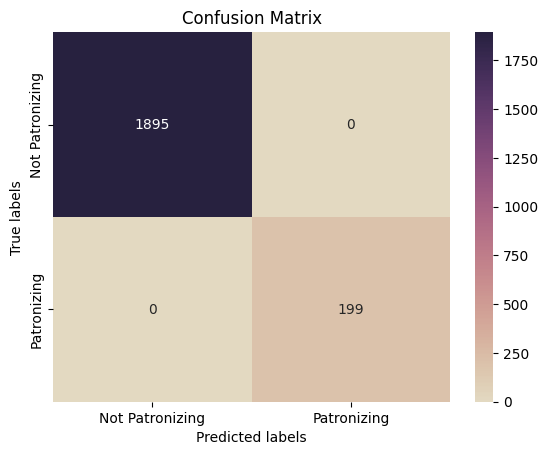

In [18]:
performance_metrics(trainer, val_dataset)

#### roberta

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 37%|███▋      | 500/1346 [01:25<02:16,  6.20it/s]

{'loss': 0.0348, 'grad_norm': 0.0015399864641949534, 'learning_rate': 1.2570579494799406e-05, 'epoch': 0.74}


                                                  
 50%|█████     | 673/1346 [02:01<01:57,  5.73it/s]Checkpoint destination directory roberta-base-cased/checkpoint-673 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 1.0382273197174072, 'eval_runtime': 6.3131, 'eval_samples_per_second': 331.693, 'eval_steps_per_second': 20.751, 'epoch': 1.0}


 74%|███████▍  | 1001/1346 [02:58<00:53,  6.41it/s]

{'loss': 0.0002, 'grad_norm': 0.0009497537394054234, 'learning_rate': 5.141158989598811e-06, 'epoch': 1.49}


                                                   
100%|██████████| 1346/1346 [04:02<00:00,  6.92it/s]Checkpoint destination directory roberta-base-cased/checkpoint-1346 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 1.0815843343734741, 'eval_runtime': 6.2387, 'eval_samples_per_second': 335.648, 'eval_steps_per_second': 20.998, 'epoch': 2.0}


100%|██████████| 1346/1346 [04:04<00:00,  5.51it/s]


{'train_runtime': 244.4188, 'train_samples_per_second': 88.013, 'train_steps_per_second': 5.507, 'train_loss': 0.01310993628617913, 'epoch': 2.0}


100%|██████████| 131/131 [00:06<00:00, 21.03it/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1895
           1       1.00      1.00      1.00       199

    accuracy                           1.00      2094
   macro avg       1.00      1.00      1.00      2094
weighted avg       1.00      1.00      1.00      2094



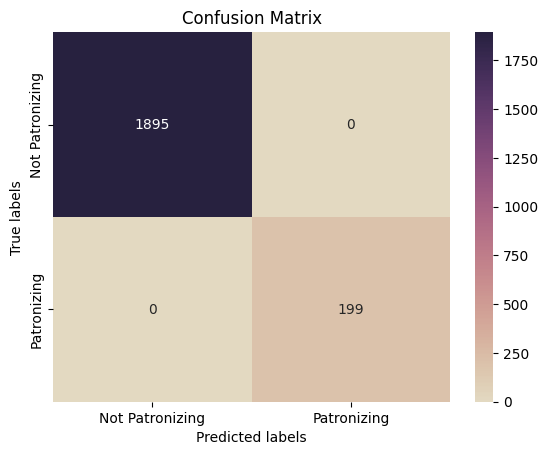

In [19]:
from transformers import RobertaTokenizer

model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/roberta-base', num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

test_dataset = PCLDataset(test_data, mask_tokens=False, tokenizer=tokenizer)
training_dataset = PCLDataset(sampled_train_data, mask_tokens=False, tokenizer=tokenizer)
val_dataset = PCLDataset(sampled_val_data, mask_tokens=False, tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="models/roberta-base-cased",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=val_dataset,
    data_collator=training_dataset.collate_fn,
)

trainer.train()

performance_metrics(trainer, val_dataset)

In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=10,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing = False,
                                      use_multiprocessing_for_evaluation = False,
                                      learning_rate=2e-5,
                                      output_dir='my_awesome_model',
                                      save_steps='epoch',
                                      )

task1_model = ClassificationModel("roberta",
                                  'roberta-base',
                                  args = task1_model_args,
                                  num_labels=2,
                                  use_cuda=torch.cuda.is_available())

# train model
task1_model.train_model(training_dataset.data[['text', 'label']])

In [ ]:
preds_task1, _ = task1_model.predict(test_dataset.data['text'].tolist())

In [ ]:
from collections import Counter
Counter(preds_task1)

In [ ]:
performance_metrics(task1_model, val_dataset)

### Vanilla Model

In [ ]:

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=5e-5)

train_model(model, optimizer)

### Some other Model

In [ ]:
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=3e-5)

train_model(model, optimizer)

In [ ]:
performance_metrics(model, val_loader)

### With Accelerator

In [ ]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_loader, val_loader, model, optimizer
)

train_model(model, optimizer, train_loader=train_dl, accelerator=accelerator)

In [ ]:
performance_metrics(model, val_loader)

### My custom layer

## Submission Documents

In [ ]:
def get_and_save_predictions(dataset, save_name, model=task1_model):
    y_pred, _ = model.predict(dataset.tolist())
    np.savetxt(f'{save_name}.txt', y_pred, fmt='%d')

# train predictions
get_and_save_predictions(test_data['text'], "test")

# test predictions
get_and_save_predictions(train_data['text'], "dev")